In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
brss = pd.read_csv('NYSDOH_BRFSS_SurveyData_2015.csv', engine='python')

In [4]:
#Summarize output variable
#Note: Uneven distribution - must be handled properly when splitting data into training/test
brss['_RFHLTH'].value_counts()

Good or Better Health                     10141
Fair or Poor Health                        2149
Don’t know/Not Sure Or Refused/Missing       67
Name: _RFHLTH, dtype: int64

In [5]:
#Remove rows where output value is unknown
brss = brss[brss['_RFHLTH']!='Don’t know/Not Sure Or Refused/Missing']

In [6]:
brss['_RFHLTH'].value_counts()

Good or Better Health    10141
Fair or Poor Health       2149
Name: _RFHLTH, dtype: int64

Notes About Demographic Data
AGE is 10 year age bands.  "AGEG5YR" has age in 5 year bands instead.
"EDUCA" has 7 education bands (vs. 5 in "EDUCAG").
"INCOME2" has more bands (and slightly messier data).

In [7]:
#Demographic data
demo = brss[['SEX','AGE','MARITAL','EDUCA','VETERAN3','EMPLOY1','_INCOMG','_CHLDCNT','dsripreg']]
demo = demo.rename({'EDUCA':'EDUCATION','VETERAN3':'VETERAN_STATUS','EMPLOY1':'EMPLOYMENT_STATUS','_INCOMG':'INCOME','_CHLDCNT':'CHILDREN','dsripreg':'REGION'},
           axis='columns')
#Encode data for analysis

#Binary variables
sex = {'Male':0,'Female':1}
demo['SEX'] = demo['SEX'].map(sex)

veteran = {'No':0,'Yes':1, 'Refused':0, 'Don’t know/Not Sure':0} #Assuming no if unknown
demo['VETERAN_STATUS'] = demo['VETERAN_STATUS'].map(veteran)

#Create a series of dummy variables for the following variables
#33% of respondents are Age 65 or older - therefore, unknown or refused will be set to the most common value
age = {'Refused': 'Age 65 or older','Don’t know/Not sure':'Age 65 or older'}
demo['AGE'] = demo['AGE'].replace(age)
age_dummy = pd.get_dummies(demo['AGE'])

#47% of respondents are married - therefore, refused will be set to married
demo['MARITAL'] = demo['MARITAL'].replace({'Refused':'Married'})
married_dummy = pd.get_dummies(demo['MARITAL'])

#43% of respondents are college graduates - therefore, refused will be set to college graduate
demo['EDUCATION'] = demo['EDUCATION'].replace({'Refused':'College 4 years or more (College graduate)'})
education_dummy = pd.get_dummies(demo['EDUCATION'])

#41% of respondents are employed for wages - therefore, refused will be set to employed
demo['EMPLOYMENT_STATUS'] = demo['EMPLOYMENT_STATUS'].replace({'Refused':'Employed for wages'})
employment_dummy = pd.get_dummies(demo['EMPLOYMENT_STATUS'])

#16% of respondents have unknown data - ask about what to do
demo['INCOME'] = demo['INCOME'].replace({'Don’t know/Not sure/Missing':'Unknown_Income'})
income_dummy = pd.get_dummies(demo['INCOME'])

region_dummy = pd.get_dummies(demo['REGION'])

#Convert description to interval variable
#72% of respondents have no children - therefore, unknown or missing will be set to 0 (no children)
equiv = {'No children in household':0,
         'One child in household':1,
         'Two children in household':2,
         'Three children in household':3,
         'Four children in household':4,
         'Five or more children in household':5,
         'Don’t know/Not sure/Missing':0}
demo['CHILD_COUNT'] = demo['CHILDREN'].map(equiv)

demo = pd.concat([demo[['SEX','VETERAN_STATUS','CHILD_COUNT']],age_dummy,education_dummy,employment_dummy,income_dummy,region_dummy],
                 axis=1)

In [8]:
temp = demo['CHILD_COUNT'].value_counts()
temp/temp.sum()

0    0.735232
1    0.113426
2    0.098047
3    0.035232
4    0.010171
5    0.007893
Name: CHILD_COUNT, dtype: float64

In [9]:
demo.columns

Index(['SEX', 'VETERAN_STATUS', 'CHILD_COUNT', 'Age 18 - 24', 'Age 25 - 34',
       'Age 35 - 44', 'Age 45 - 54', 'Age 55 - 64', 'Age 65 or older',
       'College 1 year to 3 years (Some college or technical school)',
       'College 4 years or more (College graduate)',
       'Grade 12 or GED (High school graduate)',
       'Grades 1 through 8 (Elementary)',
       'Grades 9 through 11 (Some high school)',
       'Never attended school or only kindergarten', 'A homemaker',
       'A student', 'Employed for wages', 'Out of work for 1 year or more',
       'Out of work for less than 1 year', 'Retired', 'Self-employed',
       'Unable to work', '$15,000 to less than $25,000',
       '$25,000 to less than $35,000', '$35,000 to less than $50,000',
       '$50,000 or more', 'Less than $15,000', 'Unknown_Income',
       'Capital District', 'Central New York', 'Finger Lakes', 'Long Island',
       'Mid-Hudson', 'Mohawk Valley', 'New York City', 'North Country',
       'Southern Tier', 'Tug H

In [10]:
demo.describe()

,SEX,VETERAN_STATUS,CHILD_COUNT,Age 18 - 24,Age 25 - 34,Age 35 - 44,Age 45 - 54,Age 55 - 64,Age 65 or older,College 1 year to 3 years (Some college or technical school),...,Central New York,Finger Lakes,Long Island,Mid-Hudson,Mohawk Valley,New York City,North Country,Southern Tier,Tug Hill Seaway,Western Region
count,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,...,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000
mean,0.578845,0.099430,0.495362,0.053377,0.103173,0.119203,0.174125,0.207404,0.342718,0.233930,...,0.056876,0.081448,0.119609,0.103173,0.024573,0.353702,0.034662,0.029862,0.024980,0.085110
std,0.493764,0.299251,0.968216,0.224793,0.304197,0.324040,0.379233,0.405464,0.474637,0.423345,...,0.231614,0.273534,0.324517,0.304197,0.154826,0.478138,0.182931,0.170213,0.156069,0.279056
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
demo.corr()

,SEX,VETERAN_STATUS,CHILD_COUNT,Age 18 - 24,Age 25 - 34,Age 35 - 44,Age 45 - 54,Age 55 - 64,Age 65 or older,College 1 year to 3 years (Some college or technical school),...,Central New York,Finger Lakes,Long Island,Mid-Hudson,Mohawk Valley,New York City,North Country,Southern Tier,Tug Hill Seaway,Western Region
SEX,1.000000,-0.345491,0.042382,-0.052582,-0.023824,0.010677,0.002291,0.006717,0.025314,0.027181,...,-0.021070,0.003360,-0.018232,-0.007571,0.001266,0.025079,-0.006836,-0.001390,-0.003913,0.001493
VETERAN_STATUS,-0.345491,1.000000,-0.102885,-0.054709,-0.078733,-0.079440,-0.078000,-0.060659,0.244746,0.043124,...,0.025240,0.042220,0.001540,0.006188,0.029808,-0.090553,0.009874,0.005606,0.046128,0.018510
CHILD_COUNT,0.042382,-0.102885,1.000000,0.034413,0.160488,0.368635,0.109906,-0.163270,-0.319166,-0.013731,...,-0.016060,-0.021157,0.023779,0.029806,-0.016068,0.033865,-0.011038,-0.019157,-0.017273,-0.027753
Age 18 - 24,-0.052582,-0.054709,0.034413,1.000000,-0.080541,-0.087356,-0.109034,-0.121470,-0.171467,0.048348,...,0.005767,-0.012480,-0.006095,-0.004381,0.004396,0.024205,-0.007398,-0.007633,0.001423,0.002812
Age 25 - 34,-0.023824,-0.078733,0.160488,-0.080541,1.000000,-0.124777,-0.155741,-0.173505,-0.244919,-0.019350,...,-0.017461,-0.034499,-0.023629,-0.011277,-0.022735,0.111617,-0.010166,-0.018646,-0.023438,-0.038266
Age 35 - 44,0.010677,-0.079440,0.368635,-0.087356,-0.124777,1.000000,-0.168919,-0.188186,-0.265642,-0.024147,...,-0.022034,-0.024165,0.006788,-0.003425,-0.017840,0.057157,0.007165,-0.018807,-0.007394,-0.019515
Age 45 - 54,0.002291,-0.078000,0.109906,-0.109034,-0.155741,-0.168919,1.000000,-0.234886,-0.331563,-0.004871,...,-0.002514,-0.019846,0.032423,0.019898,0.000574,-0.014326,-0.017803,0.005164,0.013121,-0.009331
Age 55 - 64,0.006717,-0.060659,-0.163270,-0.121470,-0.173505,-0.188186,-0.234886,1.000000,-0.369382,0.016930,...,0.025149,0.004687,-0.012916,-0.001312,-0.006010,-0.044739,0.023747,0.006936,0.011994,0.026649
Age 65 or older,0.025314,0.244746,-0.319166,-0.171467,-0.244919,-0.265642,-0.331563,-0.369382,1.000000,-0.004582,...,0.004027,0.056372,-0.001477,-0.003137,0.029344,-0.072356,-0.000935,0.018354,-0.001334,0.021206
College 1 year to 3 years (Some college or technical school),0.027181,0.043124,-0.013731,0.048348,-0.019350,-0.024147,-0.004871,0.016930,-0.004582,1.000000,...,0.040236,0.003398,-0.001112,-0.013031,0.025268,-0.058651,0.017175,0.004684,0.027321,0.018811


Notes About Health Care Data
"FLSHOT6" is a calculated variable, but oddly has "Age Less than 65" as one of the categories - ignore.
Same for "PNEUMO2," which makes a bit more sense, but since we have age in a different band, not worth using this version.
"HCVU651" is a more verbose alternate field for health care coverage.

Notes after processing: we need to come up with a missing imputation rule.  For some of the variables, a "don't know" or "refused" probably implies that the respondent did not do the activity (colon screening for example), however this is not as obvious for all variables.

Also, many questions have a "not asked/missing" category, which leads to a lot of missingness. Need to decide how to handle this as well.

In [12]:
brss['_AIDTST3'].unique()

array(['Yes', 'No', 'Not asked or missing', 'Don’t know/Not Sure/Refused'],
      dtype=object)

In [13]:
#Health Care data
health_care = brss[['HLTHPLN1','PERSDOC2','MEDCOST','CHECKUP1','FLUSHOT6','PNEUVAC3','HADSIGM3','_AIDTST3']]
health_care = health_care.rename({'HLTHPLN1':'INSURANCE','PERSDOC2':'DOCTOR','CHECKUP1':'RECENT_CHECKUPS','FLUSHOT6':'FLUSHOT','PNEUVAC3':'PNEUMONIASHOT','HADSIGM3':'COLON_SCREENING','_AIDTST3':'HIV_SCREENING'},
                                axis='columns')

print(health_care.columns)

#Examine each variable, and encode, dealing with missing values appropriately

#Health insurance: make binary, treating refused/don't know as missing
print('\nHealth insurance counter:\n' + str(Counter(health_care['INSURANCE'])))

insurance = {'Yes':1, 'No':0, 'Refused':np.NaN, 'Don’t know/Not sure': np.NaN}
health_care['INSURANCE'] = health_care['INSURANCE'].map(insurance)

print('\nHealth insurance tabulation after encoding:\n' + str(health_care['INSURANCE'].value_counts(dropna=False)))

#Doctor visits
print('\nCounter for doctor visit:\n' + str(Counter(health_care['DOCTOR'])))

#Encode to binary: do you have a personal doctor? Encoding dkr as no
doctor = {'Yes, only one':1, 'More than one':1, 'No':0, 'Refused':0, 'Don’t know/Not Sure': 0}
health_care['DOCTOR'] = health_care['DOCTOR'].map(doctor)

print('\nDoctor tabulation after encoding:\n' + str(health_care['DOCTOR'].value_counts(dropna=False)))

#Medical cost
print('\nCounter for medical costs:\n' + str(Counter(health_care['MEDCOST'])))

#Encode to binary: do you have a personal doctor? Encoding dkr as missing
medcost = {'Yes':1, 'No':0, 'Refused':np.NaN, 'Don’t know/Not sure': np.NaN}
health_care['MEDCOST'] = health_care['MEDCOST'].map(medcost)

print('\nMedcost tabulation after encoding:\n' + str(health_care['MEDCOST'].value_counts(dropna=False)))

#Recent checkups
print('\nCounter for recent checkups:\n' + str(Counter(health_care['RECENT_CHECKUPS'])))

#Create dummy variables from categories
health_care['RECENT_CHECKUPS'] = health_care['RECENT_CHECKUPS'].replace({'Refused':'Unknown_Checkup', 
                                                                         'Don’t know/Not sure':'Unknown_Checkup',
                                                                         'Within past year (anytime less than 12 months ago)':'Checkup within past year',
                                                                         'Within past 2 years (1 year but less than 2 years ago)':'Checkup within past 2 years',
                                                                         'Within past 5 years (2 years but less than 5 years ago)':'Checkup within past 5 years',
                                                                         'Never':'Checkup never',
                                                                         '5 or more years ago':'Checkup 5 or more years ago'})
recent_checkup_dummies = pd.get_dummies(health_care['RECENT_CHECKUPS'])
print()
print(recent_checkup_dummies.head())

#Flu shot
print('\nCounter for flu shot:\n' + str(Counter(health_care['FLUSHOT'])))

#Encode to binary: Encoding dkr as missing
flushot = {'Yes':1, 'No':0, 'Not asked or Missing':np.NaN, 'Refused':np.NaN, 'Don’t know/Not Sure': np.NaN}
health_care['FLUSHOT'] = health_care['FLUSHOT'].map(flushot)

print('\nFlu shot tabulation after encoding:\n' + str(health_care['FLUSHOT'].value_counts(dropna=False)))

#Pneumonia shot
print('\nCounter for pneumonia shot:\n' + str(Counter(health_care['PNEUMONIASHOT'])))

#Encode to binary: Encoding dkr as missing
pneumoniashot = {'Yes':1, 'No':0, 'Not asked or Missing':np.NaN, 'Refused':np.NaN, 'Don’t know/Not Sure': np.NaN}
health_care['PNEUMONIASHOT'] = health_care['PNEUMONIASHOT'].map(pneumoniashot)

print('\nPneumonia shot tabulation after encoding:\n' + str(health_care['PNEUMONIASHOT'].value_counts(dropna=False)))

#Colon screening
print('\nCounter for colon screening:\n' + str(Counter(health_care['COLON_SCREENING'])))

#Encode to binary, treating dkr as 0
colon = {'Yes':1, 'No':0, 'Not asked or Missing':np.NaN, 'Refused':0, 'Don’t know/Not Sure': 0}
health_care['COLON_SCREENING'] = health_care['COLON_SCREENING'].map(colon)

print('\nColon screening tabulation after encoding:\n' + str(health_care['COLON_SCREENING'].value_counts(dropna=False)))

#HIV screening
print('\nCounter for HIV screening:\n' + str(Counter(health_care['HIV_SCREENING'])))

#Encode to binary, treating dkr as 0
hiv = {'Yes':1, 'No':0, 'Not asked or missing':np.NaN, 'Don’t know/Not Sure/Refused': 0}
health_care['HIV_SCREENING'] = health_care['HIV_SCREENING'].map(hiv)

print('\nHIV screening tabulation after encoding:\n' + str(health_care['HIV_SCREENING'].value_counts(dropna=False)))

#combine columns into final data frame
health_care = pd.concat([health_care[['INSURANCE','DOCTOR','MEDCOST','FLUSHOT','PNEUMONIASHOT','COLON_SCREENING',
                                    'HIV_SCREENING']],recent_checkup_dummies],axis=1)

Index(['INSURANCE', 'DOCTOR', 'MEDCOST', 'RECENT_CHECKUPS', 'FLUSHOT',
       'PNEUMONIASHOT', 'COLON_SCREENING', 'HIV_SCREENING'],
      dtype='object')

Health insurance counter:
Counter({'Yes': 11486, 'No': 762, 'Refused': 23, 'Don’t know/Not Sure': 19})

Health insurance tabulation after encoding:
 1.0    11486
 0.0      762
NaN        42
Name: INSURANCE, dtype: int64

Counter for doctor visit:
Counter({'Yes, only one': 9888, 'No': 1405, 'More than one': 905, 'Refused': 54, 'Don’t know/Not Sure': 38})

Doctor tabulation after encoding:
1    10793
0     1497
Name: DOCTOR, dtype: int64

Counter for medical costs:
Counter({'No': 11113, 'Yes': 1135, 'Refused': 25, 'Don’t know/Not sure': 17})

Medcost tabulation after encoding:
 0.0    11113
 1.0     1135
NaN        42
Name: MEDCOST, dtype: int64

Counter for recent checkups:
Counter({'Within past year (anytime less than 12 months ago)': 9414, 'Within past 2 years (1 year but less than 2 years ago)': 1393, 'Within past 5 years (2 years 

In [14]:
health_care.describe()

,INSURANCE,DOCTOR,MEDCOST,FLUSHOT,PNEUMONIASHOT,COLON_SCREENING,HIV_SCREENING,Checkup 5 or more years ago,Checkup never,Checkup within past 2 years,Checkup within past 5 years,Checkup within past year,Unknown_Checkup
count,12248.000000,12290.000000,12248.000000,10722.000000,9817.000000,3398.000000,10684.00000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000
mean,0.937786,0.878194,0.092668,0.479761,0.411837,0.754267,0.39985,0.044101,0.005614,0.113344,0.062327,0.765989,0.008625
std,0.241554,0.327075,0.289979,0.499614,0.492191,0.430584,0.48989,0.205328,0.074721,0.317026,0.241759,0.423397,0.092473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Notes on behavorial risks:
Raw Smoking Data: SMOKE100, SMOKDAY2, STOPSMK2, LASTSMK2, USENOW3
"RFSMOK3" current smoker info - not as informative as the field used ("SMOKER3")
Raw Alcohol Data: ALCDAY5, AVEDRNK2, DRNK3GE5, MAXDRNKS
Computed Alcohol Variables: DRNKANY5, DROCDY3_, _RFBING5, _DRNKWEK, _RFDRHV5
Suggest we use "_DRNKWEK" which represents the computed number od drinks per week (continuous variable)
Seat Belt Use: '_RFSEAT2' selected over '_RFSEAT3' and 'SEATBELT'

Drinks per week variable has almost a majority of unreasonable values.  I topcoded for now, but we may want to throw out this variable altogether, or make it a binary for more or less than 10 drinks a week or something along those lines.

I also changed the seatbelt use variable to a binary since there were only two categories.

In [15]:
#Behavorial Risk Data
behavior = brss[['_SMOKER3','_DRNKWEK','_RFSEAT2']]
behavior = behavior.rename({'_SMOKER3':'SMOKER','_DRNKWEK':'DRINKS_PER_WEEK','_RFSEAT2':'SEATBELT_USE'},
                          axis='columns')

In [16]:
behavior[['SMOKER','SEATBELT_USE']].describe()

,SMOKER,SEATBELT_USE
count,12290,12290
unique,5,3
top,Never smoked,Always or Almost Always Wear Seat Belt
freq,6588,10203


In [17]:
#Max value of 99,990 looks fishy
behavior[['DRINKS_PER_WEEK']].describe()

,DRINKS_PER_WEEK
count,12290.000000
mean,7889.180553
std,26502.028813
min,0.000000
25%,0.000000
50%,47.000000
75%,400.000000
max,99900.000000


In [18]:
#Clean behavior data
#Read in data again so cell can be run on its own
behavior = brss[['_SMOKER3','_DRNKWEK','_RFSEAT2']]
behavior = behavior.rename({'_SMOKER3':'SMOKER','_DRNKWEK':'DRINKS_PER_WEEK','_RFSEAT2':'SEATBELT_USE'},
                          axis='columns')

print(behavior.columns)

#Smoking
print('\nCounter for smoker:\n' + str(Counter(behavior['SMOKER'])))

#Create dummy variables from categories
behavior['SMOKER'] = behavior['SMOKER'].replace({'Don’t know/Refused/Missing':'Unknown_Smoker', 
                                                 'Current smoker - now smokes every day':'Current daily smoker',
                                                 'Current smoker - now smokes some days':'Current occasional smoker'})

smoker_dummies = pd.get_dummies(behavior['SMOKER'])
print()
print(smoker_dummies.head())

#Drinks per week
print(pd.crosstab(index=behavior['DRINKS_PER_WEEK'],columns="count"))

#This variable is absurd.  Assuming an incredibly high 10 drinks per day gives us a max of 70 per week
#which only about 6300 people are under. Either topcode or throw this variable out. For now I will
#topcode

behavior['DRINKS_PER_WEEK'] = np.where(behavior.DRINKS_PER_WEEK > 70, 70, behavior.DRINKS_PER_WEEK)
print(pd.crosstab(index=behavior['DRINKS_PER_WEEK'],columns="count"))

#Seatbelt use
print('\nCounter for seatbelt use:\n' + str(Counter(behavior['SEATBELT_USE'])))

#Create binary variable
behavior['SEATBELT_USE'] = behavior['SEATBELT_USE'].replace({'Always or Almost Always Wear Seat Belt':'Seatbelt: always or almost always', 
                                                             'Don’t know/Not Sure Or Refused/Missing':'Seatbelt: unknown',
                                                             'Sometimes, Seldom, or Never Wear Seat Belt':'Seatbelt: sometimes to never'})

#Encode to binary, treating dkr as 0
seatbelt = {'Seatbelt: always or almost always':1, 'Seatbelt: sometimes to never':0, 'Seatbelt: unknown':np.NaN}
behavior['SEATBELT_USE'] = behavior['SEATBELT_USE'].map(seatbelt)

print('\nSeatbelt tabulation after encoding:\n' + str(behavior['SEATBELT_USE'].value_counts(dropna=False)))

#Construct final data frame
behavior = pd.concat([behavior[['DRINKS_PER_WEEK','SEATBELT_USE']],smoker_dummies],axis=1)

print(behavior.describe())

Index(['SMOKER', 'DRINKS_PER_WEEK', 'SEATBELT_USE'], dtype='object')

Counter for smoker:
Counter({'Never smoked': 6588, 'Former smoker': 3460, 'Current smoker - now smokes every day': 1076, 'Don’t know/Refused/Missing': 673, 'Current smoker - now smokes some days': 493})

   Current daily smoker  Current occasional smoker  Former smoker  \
0                     0                          0              0   
1                     0                          0              0   
2                     0                          0              0   
3                     0                          0              0   
4                     0                          0              0   

   Never smoked  Unknown_Smoker  
0             1               0  
1             1               0  
2             1               0  
3             1               0  
4             1               0  
col_0            count
DRINKS_PER_WEEK       
0                 5058
23                 671
47             

There are a lot of categories/variables on physical activity - split this out into its own grouping (separate it from behaviorial risk factors)

In [19]:
activity = brss[['_TOTINDA','PA1MIN_','PA1VIGM_']]
activity = activity.rename({'_TOTINDA':'ACTIVE_LAST30DAYS','PA1MIN_':'MINS_OF_PHYS_ACTIVITY_PERWEEK',
                           'PA1VIGM_':'MINS_OF_VIGOROUS_ACTIVITY_PERWEEK'},
                          axis='columns')

In [20]:
activity['ACTIVE_LAST30DAYS'].describe()

count                                 12290
unique                                    3
top       Had physical activity or exercise
freq                                   7806
Name: ACTIVE_LAST30DAYS, dtype: object

In [21]:
activity[['MINS_OF_PHYS_ACTIVITY_PERWEEK','MINS_OF_VIGOROUS_ACTIVITY_PERWEEK']].describe()

,MINS_OF_PHYS_ACTIVITY_PERWEEK,MINS_OF_VIGOROUS_ACTIVITY_PERWEEK
count,7547.000000,7594.000000
mean,424.843116,114.668027
std,633.137789,278.014490
min,0.000000,0.000000
25%,120.000000,0.000000
50%,252.000000,0.000000
75%,500.000000,135.000000
max,22364.000000,11182.000000


In [22]:
#Clean and combine data
#read in data again so cell can be run alone
activity = brss[['_TOTINDA','PA1MIN_','PA1VIGM_']]
activity = activity.rename({'_TOTINDA':'ACTIVE_LAST30DAYS',
                            'PA1MIN_':'MINS_OF_PHYS_ACTIVITY_PERWEEK',
                            'PA1VIGM_':'MINS_OF_VIGOROUS_ACTIVITY_PERWEEK'},
                            axis='columns')

#Active last 30 days
print('\nCounter for active last 30 days:\n' + str(Counter(activity['ACTIVE_LAST30DAYS'])))

#Encode to binary, keeping dkr as missing
active = {'Had physical activity or exercise':1, 
            'No physical activity or exercise in last 30 days':0, 
            'Don’t know/Refused/Missing':np.NaN}
activity['ACTIVE_LAST30DAYS'] = activity['ACTIVE_LAST30DAYS'].map(active)

print('\nActive last 30 days tabulation after encoding:\n' + str(activity['ACTIVE_LAST30DAYS'].value_counts(dropna=False)))

#need to topcode mins of activity variables
print(activity.describe())

#topcode physical activity per week at 5040, 12 hours per day
#topcode vigorous physical activity at 1680, 3 hours per day

activity['MINS_OF_PHYS_ACTIVITY_PERWEEK'] = np.where(activity.MINS_OF_PHYS_ACTIVITY_PERWEEK > 5040, 5040, activity.MINS_OF_PHYS_ACTIVITY_PERWEEK)
print(pd.crosstab(index=activity['MINS_OF_PHYS_ACTIVITY_PERWEEK'],columns="count"))

activity['MINS_OF_VIGOROUS_ACTIVITY_PERWEEK'] = np.where(activity.MINS_OF_VIGOROUS_ACTIVITY_PERWEEK > 1680, 1680, activity.MINS_OF_VIGOROUS_ACTIVITY_PERWEEK)
print(pd.crosstab(index=activity['MINS_OF_VIGOROUS_ACTIVITY_PERWEEK'],columns="count"))


Counter for active last 30 days:
Counter({'Had physical activity or exercise': 7806, 'No physical activity or exercise in last 30 days': 3107, 'Don’t know/Refused/Missing': 1377})

Active last 30 days tabulation after encoding:
 1.0    7806
 0.0    3107
NaN     1377
Name: ACTIVE_LAST30DAYS, dtype: int64
       ACTIVE_LAST30DAYS  MINS_OF_PHYS_ACTIVITY_PERWEEK  \
count       10913.000000                    7547.000000   
mean            0.715294                     424.843116   
std             0.451295                     633.137789   
min             0.000000                       0.000000   
25%             0.000000                     120.000000   
50%             1.000000                     252.000000   
75%             1.000000                     500.000000   
max             1.000000                   22364.000000   

       MINS_OF_VIGOROUS_ACTIVITY_PERWEEK  
count                        7594.000000  
mean                          114.668027  
std                           278

Raw nutrition variables:
FRUITJU1
FRUIT1
FVBEANS
FVGREEN
FVORANG
VEGETAB1
Use total fruits and vegetable intake per day

In [20]:
#Nutrtion Data
nutrition = brss[['_FRUTSUM','_VEGESUM']]
nutrition = nutrition.rename({'_FRUTSUM':'FRUITS_PER_DAY','_VEGESUM':'VEGGIES_PER_DAY'},
                            axis='columns')

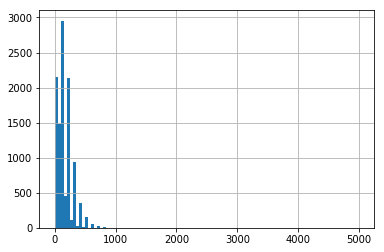

In [21]:
nutrition['FRUITS_PER_DAY'].hist(bins=100)

In [22]:
#Values look high/odd --Do this one
nutrition.describe()

,FRUITS_PER_DAY,VEGGIES_PER_DAY
count,10860.000000,10646.000000
mean,149.375322,199.612531
std,130.437550,138.102584
min,0.000000,0.000000
25%,66.000000,110.000000
50%,114.000000,172.000000
75%,200.000000,256.000000
max,5000.000000,1900.000000


Disease comments:


In [23]:
#Disease variables
disease = brss[['_RFHYPE5','_RFCHOL','_MICHD','_ASTHMS1','CVDSTRK3','CHCSCNCR','CHCOCNCR','CHCCOPD1','HAVARTH3','ADDEPEV2','CHCKIDNY','DIABETE3','_BMI5CAT']]
disease = disease.rename({'_RFHYPE5':'HIGH_BP','_RFCHOL':'HIGH_CHOLESTEROL','_MICHD':'HEART_DISEASE',
                         '_ASTHMS1':'ASTHMA','CVDSTRK3':'STROKE','CHCSCNCR':'SKIN_CANCER','CHCOCNCR':'OTHER_CANCER',
                         'CHCCOPD1':'COPD','HAVARTH3':'ARTHRITIS','ADDEPEV2':'DEPRESSION','CHCKIDNY':'KIDNEY_DISEASE',
                         'DIABETE3':'DIABETES','_BMI5CAT':'BMI_CATEGORY'},
                        axis='columns')

#Encode data
#Binary variables
bp = {'Yes':1, 'No':0, 'Don’t know/Not Sure/Refused/Missing': 0}
#63% of respondents have normal blood pressure - set unknown to normal (0)
disease['HIGH_BP'] = disease['HIGH_BP'].map(bp)
disease['HIGH_CHOLESTEROL'] = disease['HIGH_CHOLESTEROL'].map(bp) #No unknown values

heart = {'Reported having MI or CHD':1, 'Did not report having MI or CHD':0, 'Not asked or Missing':0}
#91% of respondents do not have heart disease - therefore, set unknown to 0
disease['HEART_DISEASE'] = disease['HEART_DISEASE'].map(heart)

stroke = {'Yes':1, 'No':0, 'Don’t know/Not sure': 0, 'Refused': 0}
#96% of respondents have not had a stroke - set unknown to 0
disease['STROKE'] = disease['STROKE'].map(stroke)
#68% of respondents do not have arthritis - set unknown to 0
disease['ARTHRITIS'] = disease['ARTHRITIS'].map(stroke)
#83% of respondents are not depression - set unknown to 0
disease['DEPRESSION'] = disease['DEPRESSION'].map(stroke)

cancer = {'Yes':1, 'No':0, 'Don’t know / Not sure': 0, 'Refused': 0}
#92% of respondents do not have skin cancer - set unknown to no (0)
disease['SKIN_CANCER'] = disease['SKIN_CANCER'].map(cancer)
#90% of respondents do not have other types of cancer - set unknown to no (0)
disease['OTHER_CANCER'] = disease['OTHER_CANCER'].map(cancer)
#92% of respondents do not have COPD - set unknown to no (0)
disease['COPD'] = disease['COPD'].map(cancer)
#97% of respondents do not have kidney disease - set unknown to no (0)
disease['KIDNEY_DISEASE'] = disease['KIDNEY_DISEASE'].map(cancer)

#Create groups of dummy variables
#85% of respondents do not have asthma - therefore, set unknown to no "No_Asthma"
asthma = {'Current':'Current_Asthma', 
          'Former':'Former_Asthma', 
          'Never':'No_Asthma',
          'Don’t know/Not Sure Or Refused/Missing':'No_Asthma'}
disease['ASTHMA'] = disease['ASTHMA'].map(asthma)
asthma_dummy = pd.get_dummies(disease['ASTHMA'])

#86% of respondents do not have diabetes - therefore, set unknown to "No_Diabetes"
diabetes = {'No': 'No_Diabetes',
            'Yes': 'Yes_Diabetes',
            'No, pre-diabetes or borderline diabetes': 'Pre-diabetes',
            'Yes, but female told only during pregnancy': 'Pregnancy-related_diabetes', #Set to no?
            'Don’t know/Not Sure': 'No_Diabetes',
            'Refused': 'No_Diabetes'}
disease['DIABETES'] = disease['DIABETES'].map(diabetes)
diabetes_dummy = pd.get_dummies(disease['DIABETES'])

#Normal and Overweight each represent approximately 1/3 of the data
#Unknown is 9% of data - significant proportion
bmi = {'Don’t know/Refused/Missing':'Unknown_BMI'}
disease['BMI_CATEGORY'] = disease['BMI_CATEGORY'].replace(bmi)
bmi_dummy = pd.get_dummies(disease['BMI_CATEGORY'])

disease = pd.concat([disease[['HIGH_BP','HIGH_CHOLESTEROL','HEART_DISEASE','STROKE','ARTHRITIS','DEPRESSION',
                               'SKIN_CANCER','OTHER_CANCER','COPD','KIDNEY_DISEASE']],asthma_dummy,diabetes_dummy,bmi_dummy],
                            axis=1)

In [24]:
disease.columns

Index(['HIGH_BP', 'HIGH_CHOLESTEROL', 'HEART_DISEASE', 'STROKE', 'ARTHRITIS',
       'DEPRESSION', 'SKIN_CANCER', 'OTHER_CANCER', 'COPD', 'KIDNEY_DISEASE',
       'Current_Asthma', 'Former_Asthma', 'No_Asthma', 'No_Diabetes',
       'Pre-diabetes', 'Pregnancy-related_diabetes', 'Yes_Diabetes',
       'Normal Weight', 'Obese', 'Overweight', 'Underweight', 'Unknown_BMI'],
      dtype='object')

In [25]:
disease.describe()

,HIGH_BP,HIGH_CHOLESTEROL,HEART_DISEASE,STROKE,ARTHRITIS,DEPRESSION,SKIN_CANCER,OTHER_CANCER,COPD,KIDNEY_DISEASE,...,No_Asthma,No_Diabetes,Pre-diabetes,Pregnancy-related_diabetes,Yes_Diabetes,Normal Weight,Obese,Overweight,Underweight,Unknown_BMI
count,12290.000000,10725.000000,12290.000000,12290.000000,12221.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,...,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000
mean,0.368104,0.408578,0.077624,0.033767,0.319123,0.168348,0.073881,0.093491,0.072172,0.027421,...,0.858421,0.860049,0.014239,0.006672,0.119040,0.333849,0.237917,0.324573,0.016924,0.086737
std,0.482309,0.491594,0.267590,0.180637,0.466156,0.374190,0.261588,0.291131,0.258784,0.163312,...,0.348632,0.346950,0.118480,0.081413,0.323849,0.471606,0.425825,0.468234,0.128993,0.281461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Combine the data and force prior probabilities to be equal.

In [26]:
brss_clean=pd.concat([demo,health_care,activity,nutrition,disease,brss['_RFHLTH']],axis=1)

#brss_clean=pd.concat([demo,brss['_RFHLTH']],axis=1) #This was used just to test the classification algorithms
    
brss_clean = brss_clean.rename({'_RFHLTH':'HEALTH_STATUS'},axis='columns')

In [27]:
brss_clean.columns

Index(['SEX', 'VETERAN_STATUS', 'CHILD_COUNT', 'Age 18 - 24', 'Age 25 - 34',
       'Age 35 - 44', 'Age 45 - 54', 'Age 55 - 64', 'Age 65 or older',
       'College 1 year to 3 years (Some college or technical school)',
       'College 4 years or more (College graduate)',
       'Grade 12 or GED (High school graduate)',
       'Grades 1 through 8 (Elementary)',
       'Grades 9 through 11 (Some high school)',
       'Never attended school or only kindergarten', 'A homemaker',
       'A student', 'Employed for wages', 'Out of work for 1 year or more',
       'Out of work for less than 1 year', 'Retired', 'Self-employed',
       'Unable to work', '$15,000 to less than $25,000',
       '$25,000 to less than $35,000', '$35,000 to less than $50,000',
       '$50,000 or more', 'Less than $15,000', 'Unknown_Income',
       'Capital District', 'Central New York', 'Finger Lakes', 'Long Island',
       'Mid-Hudson', 'Mohawk Valley', 'New York City', 'North Country',
       'Southern Tier', 'Tug H

In [28]:
#Separate data set into data frame for each group to do stratified sampling
brss_fp = brss_clean[brss_clean['HEALTH_STATUS']=='Fair or Poor Health']
brss_gb = brss_clean[brss_clean['HEALTH_STATUS']=='Good or Better Health']

#Split fair or poor health into test and train data
fp_test=brss_fp.sample(frac=0.25,random_state=123)
fp_train=brss_fp.loc[brss_fp.index.difference(fp_test.index)]

#Split good or better health into test and train data
gb_test=brss_gb.sample(frac=0.25,random_state=123)
gb_train=brss_gb.loc[brss_gb.index.difference(gb_test.index)]

#Recombine
brss_test=fp_test.append(gb_test)
brss_train=fp_train.append(gb_train)

In [29]:
brss_train['HEALTH_STATUS'].value_counts()

Good or Better Health    7606
Fair or Poor Health      1612
Name: HEALTH_STATUS, dtype: int64

In [30]:
#Duplicate fair or poor health rows 4 times to even prior probabilities
brss_train_evenpp = brss_train
for i in range(4):
    brss_train_evenpp = brss_train_evenpp.append(fp_train)

In [31]:
#Prior Probabilities
prior_probs=brss_train_evenpp['HEALTH_STATUS'].value_counts()
prior_probs/prior_probs.sum()

Fair or Poor Health      0.51449
Good or Better Health    0.48551
Name: HEALTH_STATUS, dtype: float64

Run classification models.

In [32]:
#Separate predictor variables and output variables
train_predictors = brss_train_evenpp.drop('HEALTH_STATUS',axis=1)
train_classes = brss_train_evenpp['HEALTH_STATUS']

test_predictors = brss_test.drop('HEALTH_STATUS',axis=1)
test_classes = brss_test['HEALTH_STATUS']

#Classification models
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(train_predictors,train_classes)
lr_test = lr.predict(test_predictors)

from sklearn.metrics import confusion_matrix
lr_confusion_matrix = confusion_matrix(y_true=test_classes,y_pred=lr_test)
print("Logistic Regression:\n",lr_confusion_matrix)

#Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(train_predictors,train_classes)
lda_test = lda.predict(test_predictors)

lda_confusion_matrix = confusion_matrix(y_true=test_classes,y_pred=lda_test)
print("Linear Discriminant Analysis:\n",lda_confusion_matrix)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(train_predictors,train_classes)
nb_test = nb.predict(test_predictors)

nb_confusion_matrix = confusion_matrix(y_true=test_classes,y_pred=nb_test)
print("Naive Bayes:\n",nb_confusion_matrix)

#K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier  
knn1 = KNeighborsClassifier(n_neighbors=1).fit(train_predictors,train_classes)
knn1_test = knn1.predict(test_predictors)
knn1_confusion_matrix = confusion_matrix(y_true=test_classes,y_pred=knn1_test)
print("K-Nearest Neighbors (K=1):\n",knn1_confusion_matrix)

knn5 = KNeighborsClassifier(n_neighbors=5).fit(train_predictors,train_classes)
knn5_test = knn5.predict(test_predictors)
knn5_confusion_matrix = confusion_matrix(y_true=test_classes,y_pred=knn5_test)
print("K-Nearest Neighbors (K=5):\n",knn5_confusion_matrix)

knn10 = KNeighborsClassifier(n_neighbors=10).fit(train_predictors,train_classes)
knn10_test = knn10.predict(test_predictors)
knn10_confusion_matrix = confusion_matrix(y_true=test_classes,y_pred=knn10_test)
print("K-Nearest Neighbors (K=10):\n",knn10_confusion_matrix)

knn20 = KNeighborsClassifier(n_neighbors=20).fit(train_predictors,train_classes)
knn20_test = knn20.predict(test_predictors)
knn20_confusion_matrix = confusion_matrix(y_true=test_classes,y_pred=knn20_test)
print("K-Nearest Neighbors (K=20):\n",knn20_confusion_matrix)

Logistic Regression:
 [[ 353  184]
 [ 761 1774]]
Linear Discriminant Analysis:
 [[ 361  176]
 [ 774 1761]]
Naive Bayes:


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


 [[ 339  198]
 [ 755 1780]]
K-Nearest Neighbors (K=1):
 [[ 206  331]
 [ 577 1958]]
K-Nearest Neighbors (K=5):
 [[ 226  311]
 [ 530 2005]]
K-Nearest Neighbors (K=10):
 [[ 285  252]
 [ 769 1766]]
K-Nearest Neighbors (K=20):
 [[ 279  258]
 [ 638 1897]]


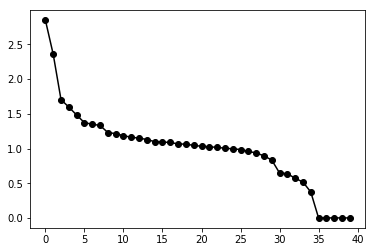

In [42]:
#Principal Component Analysis
from sklearn.preprocessing import StandardScaler

standardized_predictors = StandardScaler().fit_transform(train_predictors)
correlation = np.corrcoef(standardized_predictors)

from sklearn.decomposition import PCA
pca = PCA().fit(standardized_predictors)
eigenvalues = pca.explained_variance_

#Scree plot
plt.plot(eigenvalues, '-ok')

In [43]:
#Number of eigenvalues greater than 1
np.sum(eigenvalues>1)

24

In [37]:
#Factor analysis
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=5).fit(standardized_predictors)
fa.get_params()

fa.components_

array([[-8.87172672e-03, -1.88191902e-01,  1.14185568e-01,
         2.23508444e-02,  6.28787199e-02,  8.33446632e-02,
         6.81382276e-02,  7.49048337e-01, -7.89852928e-01,
        -5.55705811e-02,  2.08536853e-01, -1.19557855e-01,
        -4.16487183e-02, -4.72858583e-02, -9.17864075e-03,
        -5.68836817e-02, -1.55216974e-02,  5.13645212e-01,
         3.69889301e-02,  1.47553722e-02, -5.72092894e-01,
         2.60648405e-02,  5.37462293e-02, -5.89030438e-02,
        -6.75535119e-02, -3.48391152e-02,  2.12874259e-01,
        -6.81055013e-02, -6.77816552e-02,  2.58246186e-03,
         9.83838909e-03, -4.34251155e-02,  3.32003700e-03,
         1.45955259e-02, -2.69138927e-02,  2.09418381e-02,
        -5.31695819e-03, -5.71876057e-03, -1.03334601e-02,
         6.99322343e-03],
       [-5.20690133e-02, -3.51238065e-02,  1.22962258e-01,
         3.71982117e-02,  1.37088661e-01,  1.85076524e-01,
         1.54607630e-01, -4.08342086e-01,  1.91894725e-02,
        -3.07906457e-01,  8.29